#Camera calibration

###Goal


###Basics

#### Camera intrinsics

$K=
\begin{bmatrix}
f_x & 0   & c_x \\
0   & f_y & c_y \\
0   & 0   & 1
\end{bmatrix}$

#### Distortion coefficients


$x_{corrected}=x\begin{pmatrix}1 + k_1r^2 + k_2r^4 + k_3r^6\end{pmatrix}$

$y_{corrected}=y\begin{pmatrix}1 + k_1r^2 + k_2r^4 + k_3r^6\end{pmatrix}$


$x_{corrected}=x + \begin{bmatrix}2p_1xy + p_2\begin{pmatrix}r^2 + 2x^2\end{pmatrix}\end{bmatrix}$

$y_{corrected}=y + \begin{bmatrix}p_1\begin{pmatrix}r^2 + 2y^2\end{pmatrix} + 2p_2xy\end{bmatrix}$


$d=
\begin{bmatrix}
k_1 & k_2 & p_1 & p_2 & k_3
\end{bmatrix}$


###Code

In [6]:
%matplotlib inline
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load images
images = glob.glob('/home/jesus/code/opencv/samples/cpp/left*.jpg')

In [8]:
# Show images
if False:
    for fname in images:
        img = cv2.imread(fname)
        plt.axis('off')
        plt.imshow(img)
        plt.show()

In [18]:
# Compute camera calibration function

# pattern parameters
rows = 6
columns = 7

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns-1,rows-1,0)
objp = np.zeros((rows*columns,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)

def compute_calibration(images, show=False):

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (columns,rows), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            
            # Perform corner subpixel detection
            cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)
            
            if show:
                # Show chessboards detected
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                cv2.drawChessboardCorners(img, (columns,rows), corners,ret)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.axis('off')
                plt.imshow(img)
                plt.show()

    # Perform camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Compute calibration error
    n = len(objpoints)
    error = 0
    for i in range(n):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error += cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/(len(imgpoints2))
    error /= n

    return error, mtx, dist

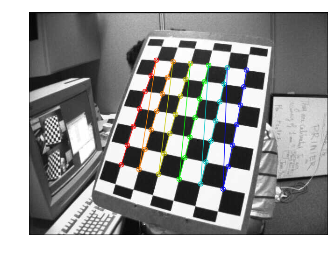

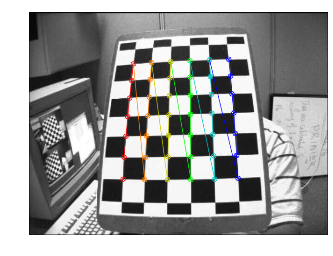

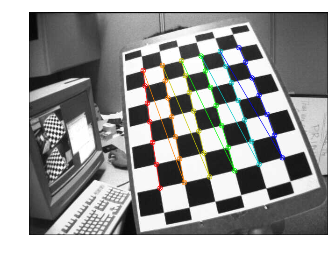

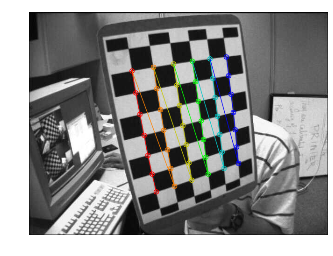

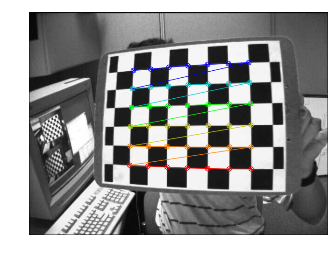

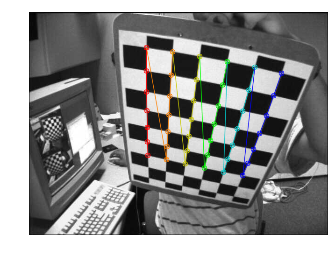

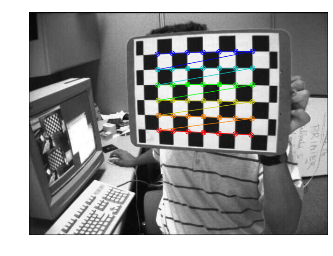

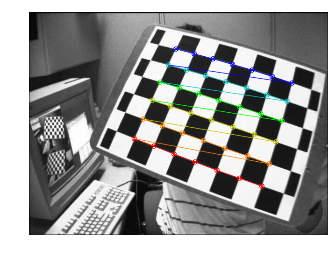

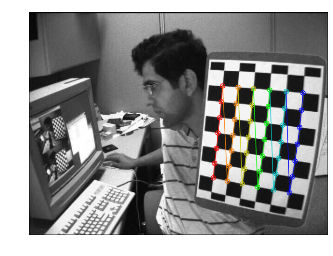

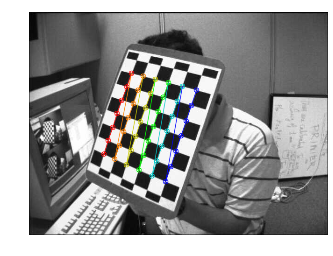


Calibration error

0.023494078351164252

Camera matrix

[[ 533.89971995    0.          342.26288877]
 [   0.          533.88322506  233.44521033]
 [   0.            0.            1.        ]]

Distortion vector

[[ -2.94746910e-01   1.13062020e-01   1.54992759e-03  -5.18622971e-05
    3.74103628e-02]]


In [19]:
# Compute calibration with all images
error, mtx, dist = compute_calibration(images, show=True)
    
print("\nCalibration error\n")
print(error)
print("\nCamera matrix\n")
print(mtx)
print("\nDistortion vector\n")
print(dist)

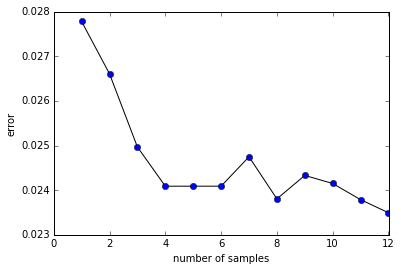

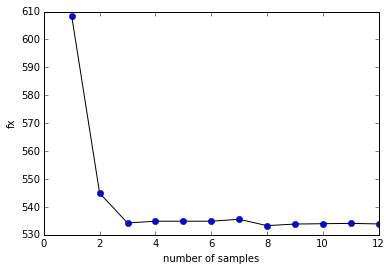

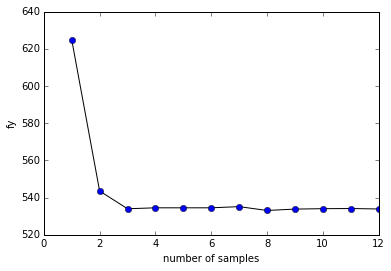

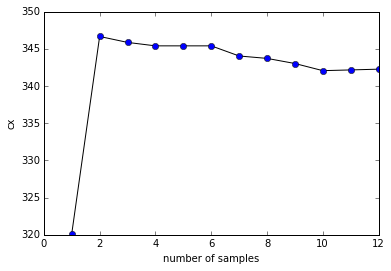

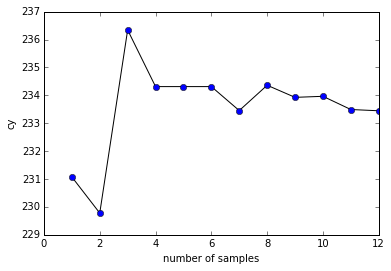

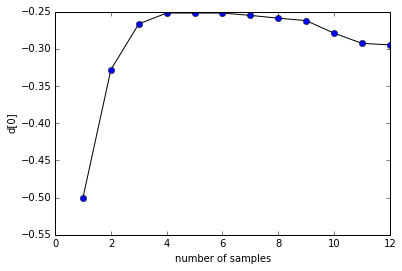

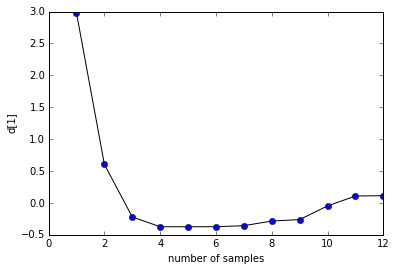

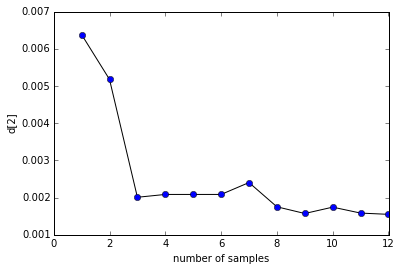

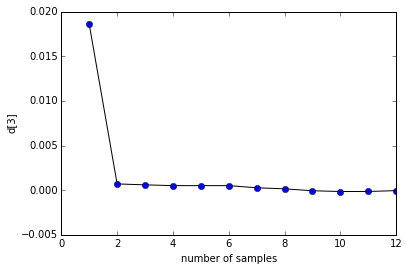

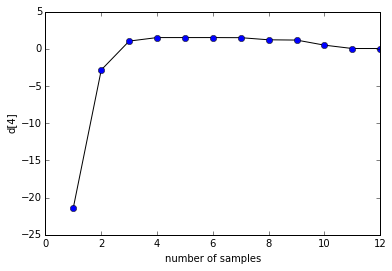

In [20]:
# Compute calibration for 1, 2, 3 ...,n images

error_list = []
mtx_list = []
dist_list = []

for i in range(1,len(images)):
    error, mtx, dist = compute_calibration(images[:i])
    error_list += [(i, error)]
    mtx_list += [mtx]
    dist_list += [dist]

def plot(title, list):
    plt.plot([x for x,_ in error_list], list,'k',
             [x for x,_ in error_list], list, 'bo')
    plt.xlabel('number of samples')
    plt.ylabel(title)
    plt.show()

plot('error', [x for _,x in error_list])    
plot('fx', [x[0][0] for x in mtx_list])
plot('fy', [x[1][1] for x in mtx_list])
plot('cx', [x[0][2] for x in mtx_list])
plot('cy', [x[1][2] for x in mtx_list])
for i in range(5):  
    plot('d[{0}]'.format(i), [x[0][i] for x in dist_list])